In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Functions for data (time series) preparation N' visualization:

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

def generate_time_series(num_samples=200):
    x = np.arange(0, num_samples)
    y = np.sin(x * 0.1) + np.random.normal(scale=0.1, size=num_samples)
    anomalies = np.random.choice(np.arange(20, num_samples-20), size=5, replace=False)
    y[anomalies] += np.random.normal(scale=2.0, size=5)  # Add anomalies
    return x, y, anomalies

def plot_time_series(x, y, anomalies=None, predictions=None, title="Time Series"):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label="True Data")
    if anomalies is not None:
        plt.scatter(x[anomalies], y[anomalies], color='red', label="Anomalies")
    if predictions is not None:
        plt.plot(x, predictions, label="Predictions", linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.show()

### 2 NN models definitions:

description:
##### I. LSTMForecaster:
*init* -\
*forward* -
##### II. LSTMAttentionForecaster:
*init* -\
*forward* -

In [3]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(LSTMForecaster, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out)

"""
   Additions:
   1. Stacked LSTM Layers to enable the model to explore the hierarchical
      patterns - multi-scale dependencies (long and short trends)
   2. Attention Mechanism to add a focus on the most relevant time steps,
      may also open possibility to interpretability of the model
   3. Dropout - stability of training and protection against overfitting
   4. Multi-Layer ANN - a trick from transformer to add capacity to the
      model and new degrees of freedom
"""

class LSTMAttentionForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2, output_dim=1, dropout=0.2):
        super(LSTMAttentionForecaster, self).__init__()
        # LSTM Layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Attention Layer
        self.attention = nn.Linear(hidden_dim, 1)

        # Fully Connected Layers for Output
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Regularization
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        # Attention Mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Fully Connected Layers
        x = self.dropout(self.relu(self.fc1(context_vector)))
        output = self.fc2(x)

        return output

Generate data and plot them:

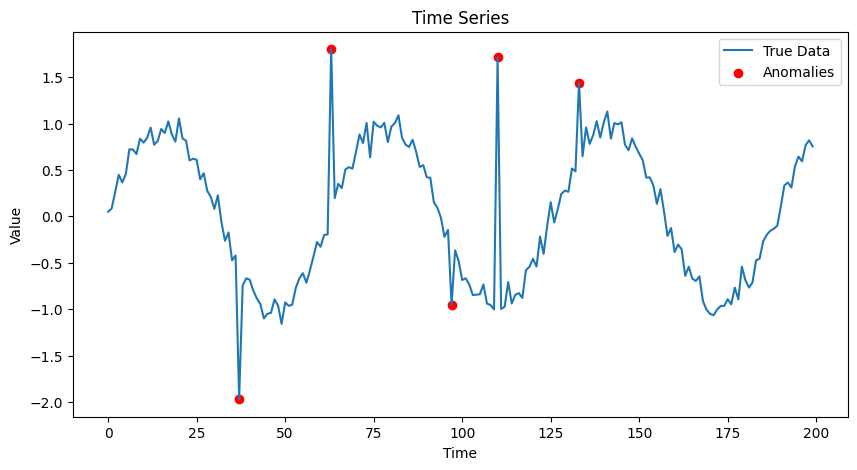

In [4]:
set_seed(42)
x, y, anomalies = generate_time_series()
plot_time_series(x, y, anomalies)
plt.show()

Create dataset to feed into the model:

In [5]:
def prepare_dataset(y, seq_len=20):
    X, Y = [], []
    for i in range(len(y) - seq_len):
        X.append(y[i:i+seq_len])
        Y.append(y[i+seq_len])
    return torch.tensor(np.array(X), dtype=torch.float32).unsqueeze(-1), torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)

seq_len = 20
X, Y = prepare_dataset(y, seq_len)

In [6]:
X[0:60].shape

torch.Size([60, 20, 1])

Train model on prepared dataset:

In [7]:
# Train a chosen model
#model = LSTMForecaster()
model = LSTMAttentionForecaster()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X[0:100])
    #loss = criterion(predictions[:, -1, :], Y)
    loss = criterion(predictions, Y[0:100])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.6100336313247681
Epoch 10, Loss: 0.4954403042793274
Epoch 20, Loss: 0.49100083112716675
Epoch 30, Loss: 0.34014731645584106
Epoch 40, Loss: 0.2349366396665573
Epoch 50, Loss: 0.14371897280216217
Epoch 60, Loss: 0.15029200911521912
Epoch 70, Loss: 0.14084476232528687
Epoch 80, Loss: 0.14196458458900452
Epoch 90, Loss: 0.13262738287448883


Predict values using trained model:

In [8]:
model.eval()
with torch.no_grad():
    #forecast = model(X).numpy().squeeze()
    forecast = model(X).numpy()

Anomaly detection:

In [9]:
residuals = np.abs(Y.numpy().squeeze() - forecast.squeeze())
threshold = np.mean(residuals) + 2 * np.std(residuals)
detected_anomalies = np.where(residuals > threshold)[0] + seq_len

Results visualisation:

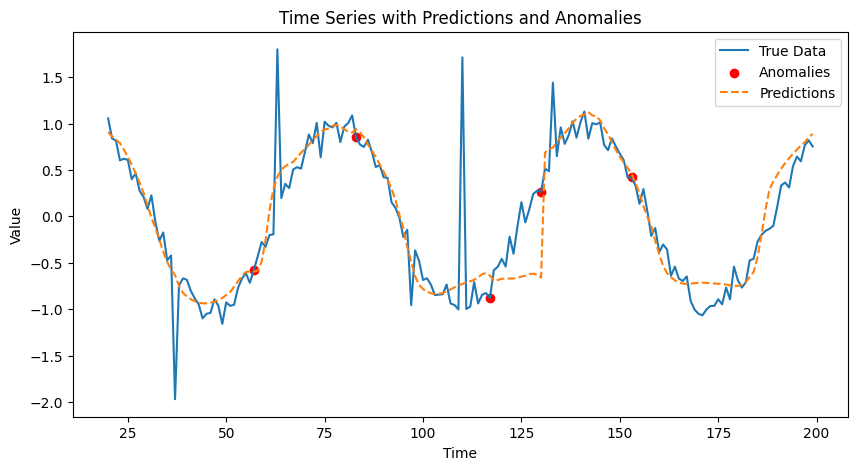

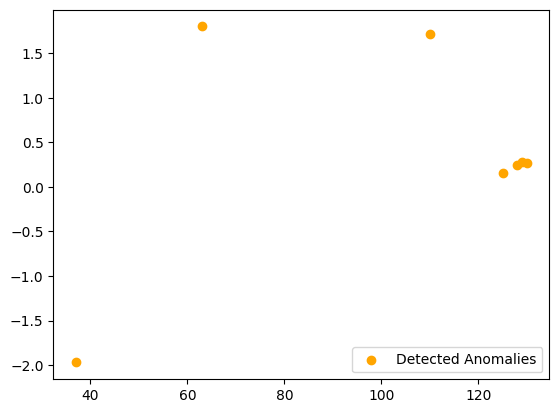

In [10]:
plot_time_series(x[seq_len:], y[seq_len:], anomalies, forecast[:, -1], title="Time Series with Predictions and Anomalies")
plt.scatter(x[detected_anomalies], y[detected_anomalies], color='orange', label="Detected Anomalies")
plt.legend()
plt.show()